In [100]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import numpy as np
from __future__ import division
import statsmodels.api as sm
from scipy.stats import pearsonr
# import seaborn as sns

mpl.rcParams['figure.figsize'] = (13,8)
# sns.set_context("talk", font_scale=1.0)

In [5]:
notas = pd.read_csv("notas_2014_2017.csv")
cpa = pd.read_csv("cpa.csv")

In [6]:
# Adicionar campo EAD a notas e cpa

notas["COD_DISCIPLINA"] = notas["COD_DISCIPLINA"].apply(lambda x: "0%s"%x if len(x)<7 else x)

In [7]:
def diff_semestres(per1,per2):
    [ano1,sem1] = per1.split("/")
    [ano2,sem2] = per2.split("/")
    d = 2*(int(ano2) - int(ano1))
    return d + (int(sem2)-int(sem1)) + 1
       
notas['diferenca_disciplina_ingresso'] = notas.apply(lambda x:diff_semestres(x['INGRESSO'],x['PERIODO']),axis=1)


In [8]:
cpa["nr_respostas"] = cpa["excelente"] + cpa["muito_bom"] + cpa["bom"] + cpa["regular"] + cpa["insuficiente"]

In [9]:
# Cálculo da nota baseado nas contagens. Está com a escala log proposta.

cpa["nota"] = 0
cpa["nota"] = (1000.0*cpa["excelente"] + 100.0*cpa["muito_bom"] + 10.0*cpa["bom"] + 1.0*cpa["regular"])/cpa["nr_respostas"]

In [10]:
# Simplificação do campo pergunta, removendo a descrição

cpa['topico'] = cpa.pergunta.apply(lambda x:x.split(':')[0].lower())

In [11]:
# Dá um número único a cada topico

cpa['id_pergunta'] = cpa.topico.rank(method='dense')

In [13]:
# Filtrar os dados de interesse da CPA.

cpa_filtered = cpa[(cpa.nr_respostas>=1) & (cpa.nr_respostas<=40)].copy()

In [14]:
turmas_df = cpa_filtered.groupby(list(cpa.columns[1:7])).nota.mean()
turmas_df = turmas_df.to_frame().reset_index()

In [15]:
turmas_df['periodo'] = turmas_df.apply(lambda x:"%s/%s"%(x['ano'],x['base_periodo_id']),axis=1)
turmas_df = turmas_df.rename(columns={'nota':'media_cpa'})

In [16]:
notas_turmas = notas[notas['SITUAÇÃO_DISCIPLINA'].isin(['Aprovado','Reprovado'])].groupby(('COD_DISCIPLINA','PERIODO','TURMA')).NOTA.mean().reset_index()
notas_turmas = notas_turmas.merge(notas[['COD_DISCIPLINA','PERIODO','TURMA','CURSO','UNIDADE']],left_on=['COD_DISCIPLINA','PERIODO','TURMA'],right_on=['COD_DISCIPLINA','PERIODO','TURMA'])

In [17]:
turmas = turmas_df.merge(notas_turmas,left_on=['periodo','cod_atividade','turma_id'],right_on=['PERIODO','COD_DISCIPLINA','TURMA'],how='left')
turmas = turmas.merge(cpa_filtered[list(cpa.columns[1:7])+['nr_respostas']],on=list(cpa.columns[1:7]),how='left')
turmas = turmas.drop_duplicates(['periodo','cod_atividade','turma_id'])
#turmas['unidade_id'] = turmas.UNIDADE.rank(method='dense')
len(turmas)


12887

In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
} 


<IPython.core.display.Javascript object>

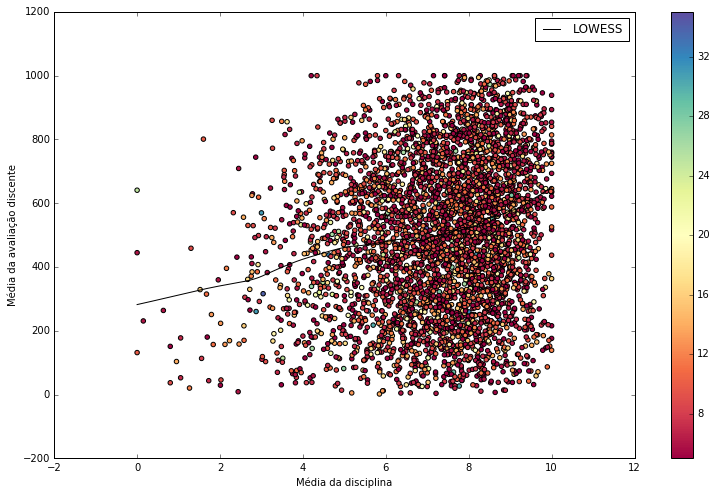

In [21]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

lowess = sm.nonparametric.lowess
z = lowess(turmas.media_cpa,turmas.NOTA,frac=0.2)

turmas_filtered = turmas[turmas.nr_respostas>=5]
#print len(turmas_filtered)

# sharex=False é devido a um bug no pandas, que oculta o xlabel com mapas de cores
ax = turmas_filtered.plot(kind='scatter',y='media_cpa',x='NOTA',c=turmas_filtered.nr_respostas,cmap=cmap,sharex=False)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.xlabel(u"Média da disciplina")
plt.ylabel(u"Média da avaliação discente")
plt.legend()
# ax.set_xlim((0,10.5))
# ax.set_ylim((0,10.5))


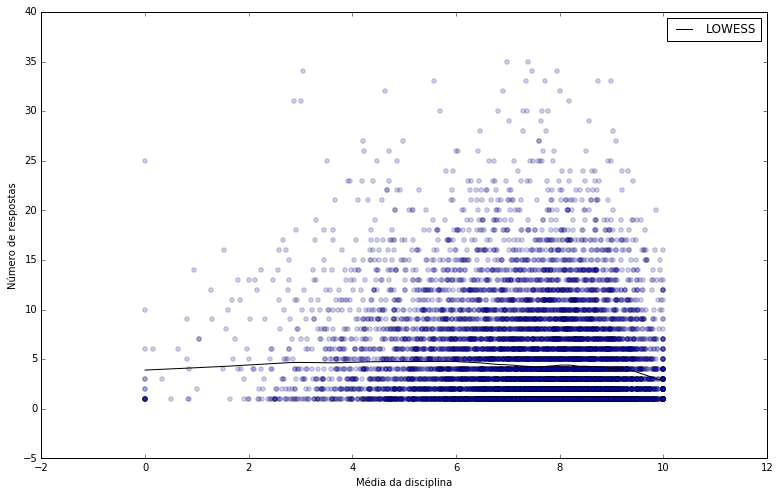

In [22]:
turmas.plot(kind='scatter',y='nr_respostas',x='NOTA',alpha=0.2)
z = lowess(turmas.nr_respostas,turmas.NOTA,frac=0.2)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.legend()
plt.xlabel(u"Média da disciplina")
plt.ylabel(u"Número de respostas")


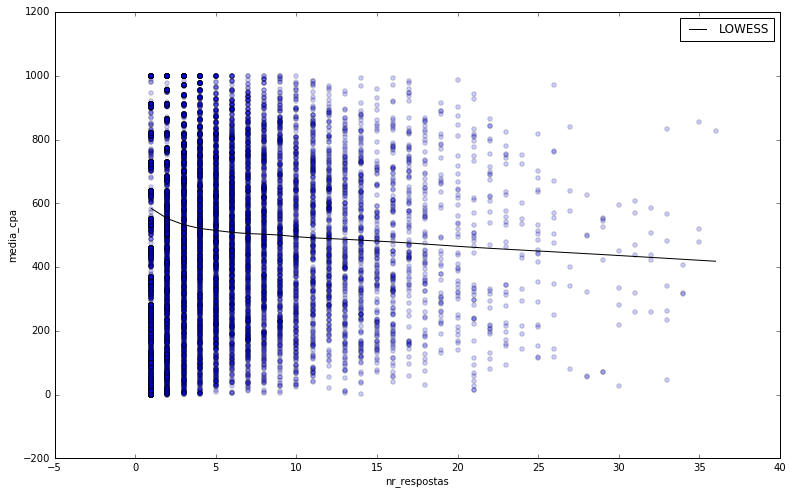

In [23]:
turmas.plot(kind='scatter',x='nr_respostas',y='media_cpa',alpha=0.2)
z = lowess(turmas.media_cpa,turmas.nr_respostas,frac=0.6)
plt.plot(z[:,0],z[:,1],color='black',label='LOWESS')
plt.legend()

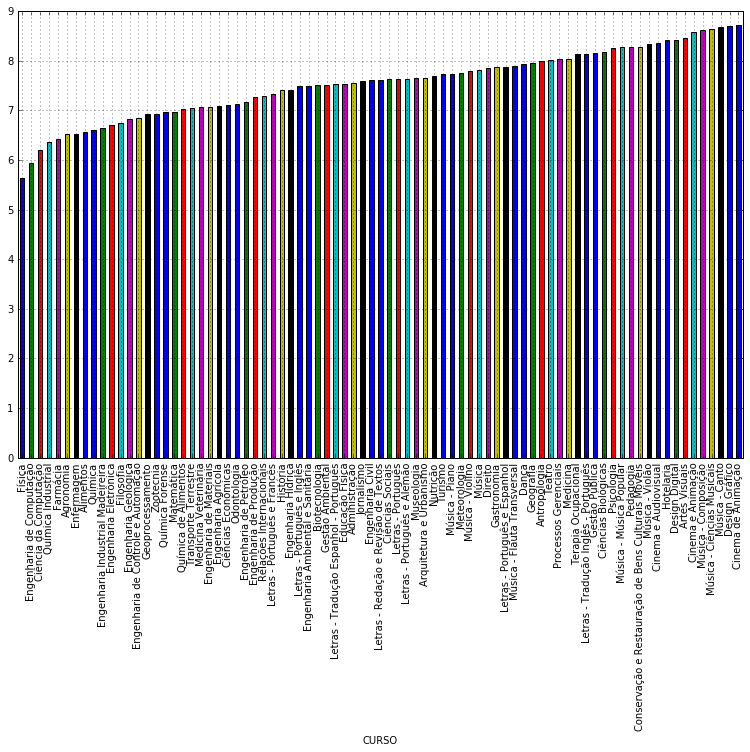

In [24]:
turmas.groupby("CURSO").NOTA.mean().sort_values().plot(kind='bar')
plt.grid()

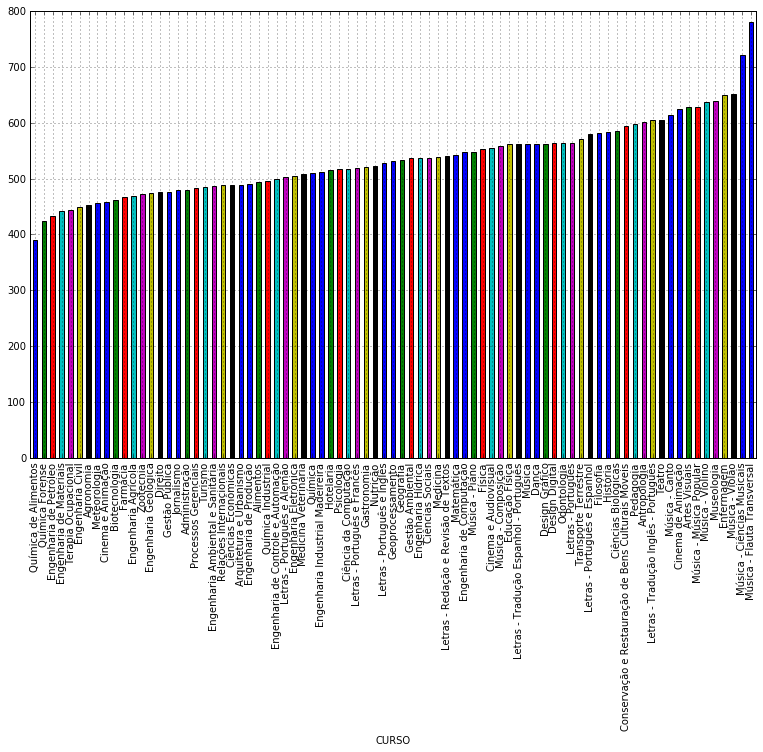

In [25]:
turmas.groupby("CURSO").media_cpa.mean().sort_values().plot(kind='bar')
plt.grid()

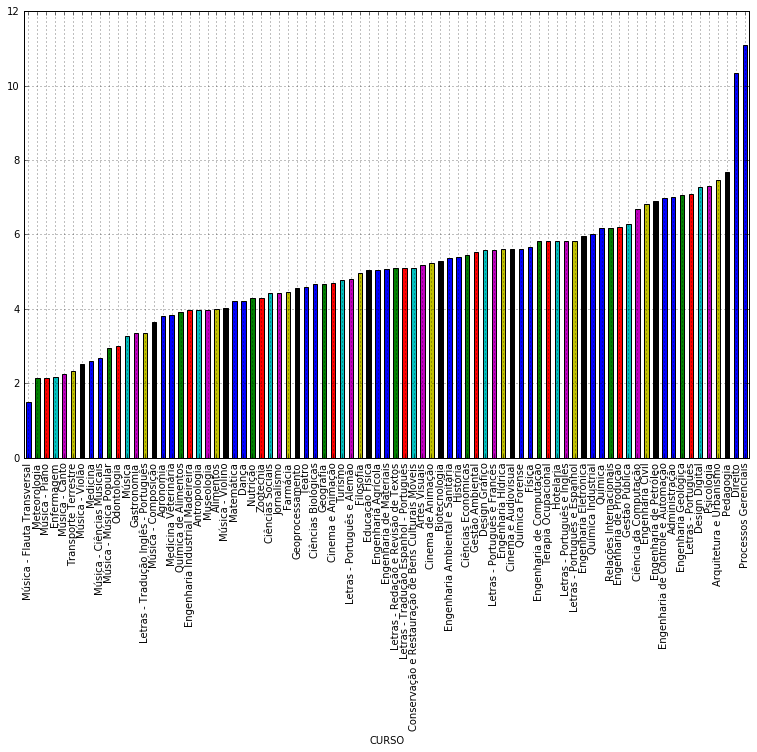

In [26]:
turmas.groupby("CURSO").nr_respostas.mean().sort_values().plot(kind='bar')
plt.grid()

- Calcular o percentual de respostas (nr_respostas / (matriculados-trancados)), plotar por curso/unidad  ver se há diferenças
- Correlação entre notas de perguntas diferentes
- Como se correlacionam notas dentro de uma edição de disciplina
- Como se correlacionam notas de professores que deram a mesma disciplina
- Os professores melhoram/pioram suas avaliações após receberem os resultados? Apenas 2016/2 para 2017/1.
- Avaliação discente varia com o semestre da disciplina?

In [90]:
cpa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171110 entries, 0 to 171109
Data columns (total 21 columns):
Unnamed: 0            171110 non-null int64
turma_id              171110 non-null int64
turma_professor_id    171110 non-null int64
ano                   171110 non-null int64
base_periodo_id       171110 non-null int64
cod_atividade         171110 non-null object
cod_turma             171110 non-null object
atividade             171110 non-null object
pergunta_id           171110 non-null int64
pergunta              171110 non-null object
excelente             171110 non-null int64
muito_bom             171110 non-null int64
bom                   171110 non-null int64
regular               171110 non-null int64
insuficiente          171110 non-null int64
nr_ordem              171110 non-null int64
cod_professor         171110 non-null float64
nr_respostas          171110 non-null int64
nota                  171110 non-null float64
topico                171110 non-null object


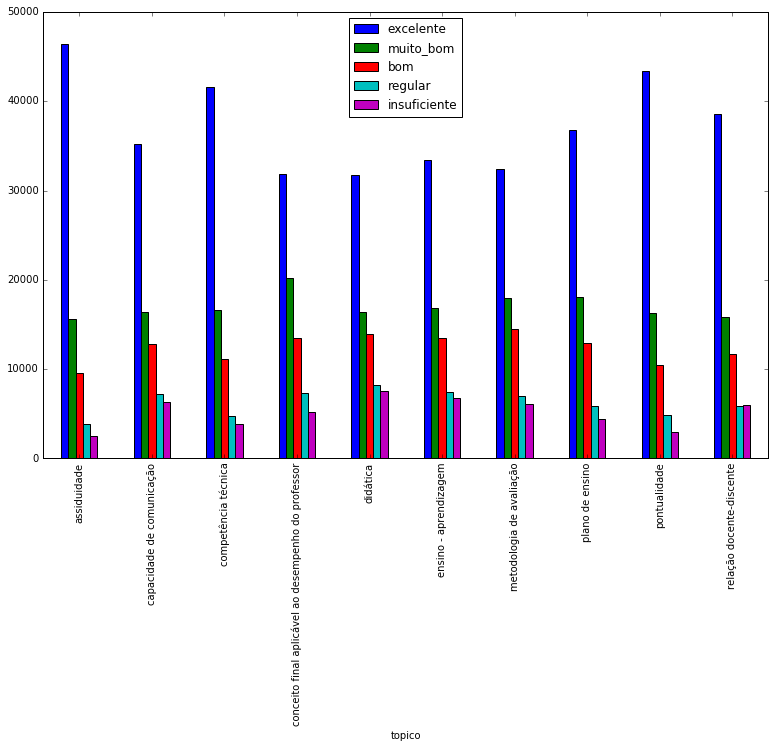

In [107]:
cpa_topico = cpa_filtered[['topico', 'excelente','muito_bom','bom','regular','insuficiente']].groupby(cpa.topico)
cpa_topico.sum().plot.bar()

In [124]:
opcoes = ['excelente', 'muito_bom', 'bom', 'regular', 'insuficiente']
topicos = cpa_filtered['topico'].unique()
respostas = []
for topico in topicos:
    for topico2 in topicos:
        for op in opcoes:
            if topico != topico2:
                a1=cpa_filtered[(cpa_filtered['topico'] == topico)][op]
                a2=cpa_filtered[(cpa_filtered['topico'] == topico2)][op]
        
                r, p = pearsonr(a1, a2)
        
                respostas.append((topico, topico2, op, r, p))
            
respostas

[('pontualidade', 'assiduidade', 'excelente', 0.91021113779671281, 0.0),
 ('pontualidade', 'assiduidade', 'muito_bom', 0.75617177553326242, 0.0),
 ('pontualidade', 'assiduidade', 'bom', 0.70700974694051399, 0.0),
 ('pontualidade', 'assiduidade', 'regular', 0.60710730336331431, 0.0),
 ('pontualidade', 'assiduidade', 'insuficiente', 0.6582592187699251, 0.0),
 ('pontualidade', 'plano de ensino', 'excelente', 0.86411182026675615, 0.0),
 ('pontualidade', 'plano de ensino', 'muito_bom', 0.6784634931835376, 0.0),
 ('pontualidade', 'plano de ensino', 'bom', 0.63788211445064369, 0.0),
 ('pontualidade', 'plano de ensino', 'regular', 0.51502524650529768, 0.0),
 ('pontualidade', 'plano de ensino', 'insuficiente', 0.5944483691260356, 0.0),
 ('pontualidade',
  'capacidade de comunica\xc3\xa7\xc3\xa3o',
  'excelente',
  0.7882365478957577,
  0.0),
 ('pontualidade',
  'capacidade de comunica\xc3\xa7\xc3\xa3o',
  'muito_bom',
  0.60588813276543385,
  0.0),
 ('pontualidade',
  'capacidade de comunica\xc

AttributeError: Cannot access callable attribute 'reset_index' of 'DataFrameGroupBy' objects, try using the 'apply' method